# Аналитический кейс 'Интернет-магазин Стримчик'

Этот проект был написан 24.03.2024.

Перед нами стоит задача анализа данных Интернет-магазина Стримчик.

Нам были переданы данные об играх, их годе выпуска, жанру, суммарным продажам по регионам, оценкам пользователей и критиков, а также о возрастном рейтинге.

После подготовки, необходимо проанализировать имеющиещиеся данные и сделать/узнать следующее:

+ Сколько игр выпускалось в разные годы? Важны ли данные за все периоды?
+ Как менялись продажи по платформам? За какой характерный срок появляются новые и исчезают старые платформы?
+ Определить актуальный период и узнать какие платформы лидируют по продажам, растут или падают?
+ Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
+ Сформулируйте выводы о зависимости между оценкой пользователей/критиков и продажами игр на различных платформах
+ Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Также необходимо составьте портрет пользователя каждого региона:
+ Самые популярные платформы (топ-5).
+ Самые популярные жанры (топ-5).
+ Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Проверить гипотезы:
+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
+ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Определить наиболее выгодные и невыгодные условия продажи игр.

## Открытие файла с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [2]:
df = pd.read_csv('games.csv')

Выведем общую информацию о загруженном датафрейме:

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Наш датафрейм состоит из следующих столбцов:
+ Name — название игры, тип клетки - строковый, есть 2 пропуска в данных
+ Platform — платформа, тип клетки - строковый, пропусков нет
+ Year_of_Release — год выпуска, тип данных - вещейственный, имеется 269 пропусков.
+ Genre — жанр игры, тип данных - строковый, имеется 2 пропуска
+ NA_sales — продажи в Северной Америке в  млн, тип данных - вещественный, пропусков нет
+ EU_sales — продажи в Европе в  млн, тип данных - вещественный, пропусков нет
+ JP_sales — продажи в Японии в  млн, тип данных - вещественный, пропусков нет
+ Other_sales — продажи в других странах в  млн, тип данных - вещественный, пропусков нет 
+ Critic_Score — оценка критиков (максимум 100), тип данных - вещественный, пропусков 8578
+ User_Score — оценка пользователей (максимум 10), тип данных - вещественный, пропусков 6701
+ Rating — рейтинг от организации ESRB, тип данных - строковый, пропусков 6766

## Подготовка данных

### Замена названия столбцов

Приведем столбцы к нижнему регистру и выведем получившиеся названия

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

#### Рассмотрим пропуски в столбце Name

In [6]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Имеется всего 2 строки с пропущенными данными в этом столбце, причем для этих игр не указаны ни жанр, ни оценки, ни рейтинг. Возможно пропуски в данном случае появились из-за того, что игры достаточно старые и название и вышеперечисленные данные о них просто не сохранились. 
Можем удалить эти игры, так как пропусков немного и на общий анализ потеря данных скажется незначительно.

In [7]:
df.dropna(subset=['name'], inplace=True)

In [8]:
df['name'].isna().sum()

0

#### Рассмотрим пропуски в столбце year_of_release

In [9]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Как видно по некоторым строкам, в некоторых названиях игр указан год (например Madden NFL 2004), скорее всего он и является годом выпуска. Заполним пропуски для таких игр.

In [10]:
years = df['name'].str.extract(r'(19[7-9][0-9]|20[0-9][0-9])',expand=False)
df['year_of_release'] = df['year_of_release'].fillna(pd.to_numeric(years))

Посмотрим сколько пропусков осталось

In [11]:
df['year_of_release'].isna().sum()

252

У нас также есть игры с одинаковыми названиями но выпущенные на разных платформах (например LEGO Harry Potter: Years 5-7). Однако, чаще всего игры выпускают на разных платформах с разницей в несколько лет, такие пропуски релеватно мы заполнить не можем. Как и остальные, информации, о которых у нас нет.

#### Рассмотрим пропуски в столбце genre

In [12]:
df['genre'].isna().sum()

0

Пропуски в столбце жанр были удалены в предыдущих пунктах.

#### Рассмотрим пропуски в столбце critic_score и user_score

In [13]:
print('Пропуски в user_score', df['critic_score'].isna().sum())
print('Пропуски в user_score', df['user_score'].isna().sum())

Пропуски в user_score 8576
Пропуски в user_score 6699


Пропусков в этих данных достаточно много. Однако мы не можем заполнить эти пропуски релевантно. В зависимости от платформы оценка от критиков и пользователей может разниться(может отличаться степень оптимизации, удобство управления и прочее). Оставляем пропуски в столбце critic_score = NaN.

Посмотрим на уникальные значения в столбце с оценкой пользователей.

In [14]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо Nan там имеется оценка tbd, что означает, что оценки пока нет, но в скором времени анонсируют. Мы можем заменить такие данные на NaN.

In [15]:
df[df['user_score']=='tbd']['user_score'] = np.nan

C:\Users\Dasha\AppData\Local\Temp\ipykernel_12852\2977818006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['user_score']=='tbd']['user_score'] = np.nan


#### Рассмотрим пропуски в столбце rating

In [16]:
df['rating'].isna().sum()

6764

Пропуски можно оставить NaN. Возможно заявка в ESRB на оценку рейтинга просто не была подана или же можно заменить на оценку RP, что означает что заявка на оценку была отправлена, но пока ещё не определена. Поступим 2 образом.

In [17]:
df['rating'] = df['rating'].fillna('RP')

#### Подведем итоги замены пропусков

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16461 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           16713 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


### Изменение типа данных

Изменим данные столбца **year_of_release** на int. Так как год выпуска не может быть дробным (так как у нас не указана конкретная дата).

In [19]:
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.,   nan])

In [20]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

Изменим данные столбца 	 **critic_score** на int. Так как все представленные оценки - целого типа.

In [21]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [22]:
df['critic_score'] = df['critic_score'].astype('Int64')

Изменим данные столбца  **user_score** на float. Потому что пользователи ставят дробные числовые оценки.

In [23]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [24]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Подтвердим что тип данных изменился

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16461 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.6+ MB


### Обработка дубликатов

Посчитаем полные дубликаты и удалим их, если они есть

In [26]:
df.duplicated().sum()

0

Полные дубликаты отсутствуют

### Добавление нового столбца с суммарными продажами во всех регионах

In [27]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [28]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,RP,31.38


**ИТОГИ**:
+ Название столбцов были приведены к нижнему регистру
+ Были обработаны пропуски в следующих столбцах:
    + name - две строки были удалены
    + year_of_release - часть значений была заменена на, год релиза содержащийся в названии игры, остальное оставлено без изменений
    + genre - были удалены вместе с пропусками в name
    + critic_score - оставлено без изменений
    + user_score - к пропускам добавились значения tbd, остальное оставлено без изменений
    + rating - часть пропусков была заполнена значениями из одинаковых игр с разных платформ, оставшиеся значениями RP
+ Были изменены типы столбцов year_of_release,critic_score на int, а user_score на float
+ Был добавлен новый столбец с суммарными продажами по всем регионам

## Анализ данных

### Сколько игр выпускалось в разные годы.

Построим гистограмму по столбцу year_of_release

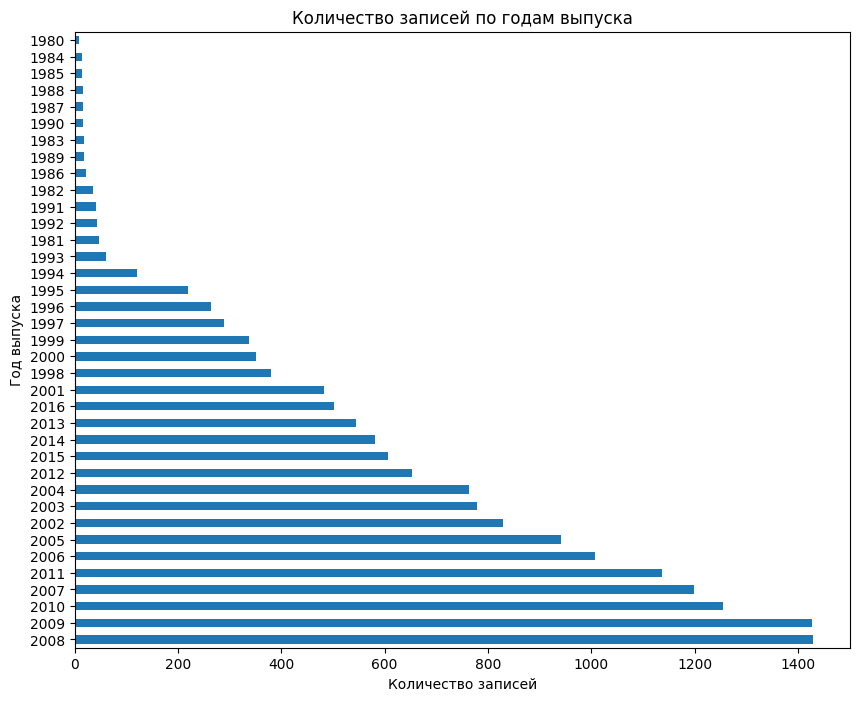

In [29]:
df['year_of_release'].value_counts().plot.barh(figsize=(10,8))
plt.xlabel('Количество записей')
plt.ylabel('Год выпуска')
plt.title('Количество записей по годам выпуска')
plt.show()

In [30]:
df['year_of_release'].describe()

count        16461.0
mean     2006.485633
std         5.873318
min           1980.0
25%           2003.0
50%           2007.0
75%           2010.0
max           2016.0
Name: year_of_release, dtype: Float64

In [31]:
df['year_of_release'].quantile(q=0.1)

1999

**Вывод**:

Из этой диаграммы видно, что большая часть игр приходилась на период после 1999 года, а точнее более 99% всей выборки. Однако сказать что данные за предыдущие года нам не важны - сложно, так как многое зависит от задачи.
Например возможно нам было бы необходимо сравнить какие жанры были популярны до 2000 и после, и тогда значения могли бы сильно отличаться, так как до 2000 не было такого большого разнообразия игр как сейчас.

### Как менялись продажи по платформам. 

Сгруппируем данные по платформам и рассчитаем суммарные продажи. 
Выведем последние 10 самых прибыльных платформ платформ.

In [32]:
top_salers = df.groupby('platform')['total_sales'].sum().sort_values().tail(10)
top_salers

platform
PC       259.52
PSP      294.05
PS4      314.14
GBA      317.85
PS       730.86
DS       806.12
Wii      907.51
PS3      939.65
X360     971.42
PS2     1255.77
Name: total_sales, dtype: float64

In [33]:
top_salers = top_salers.index
top_salers

Index(['PC', 'PSP', 'PS4', 'GBA', 'PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2'], dtype='object', name='platform')

Из этой таблицы можно сделать вывод, что самые продаваемые игры выходили на PS2, на втором и третьем местах расположились X360 и PS3. Завершает топ игры на компьютере (PC)

Построим распределения по суммарным продажам за года для последних 10 платформ.

In [34]:
grouped = (df[df['platform'].isin(top_salers)]
           .groupby(['platform','year_of_release'])['total_sales']
           .sum()
           .unstack()
          )

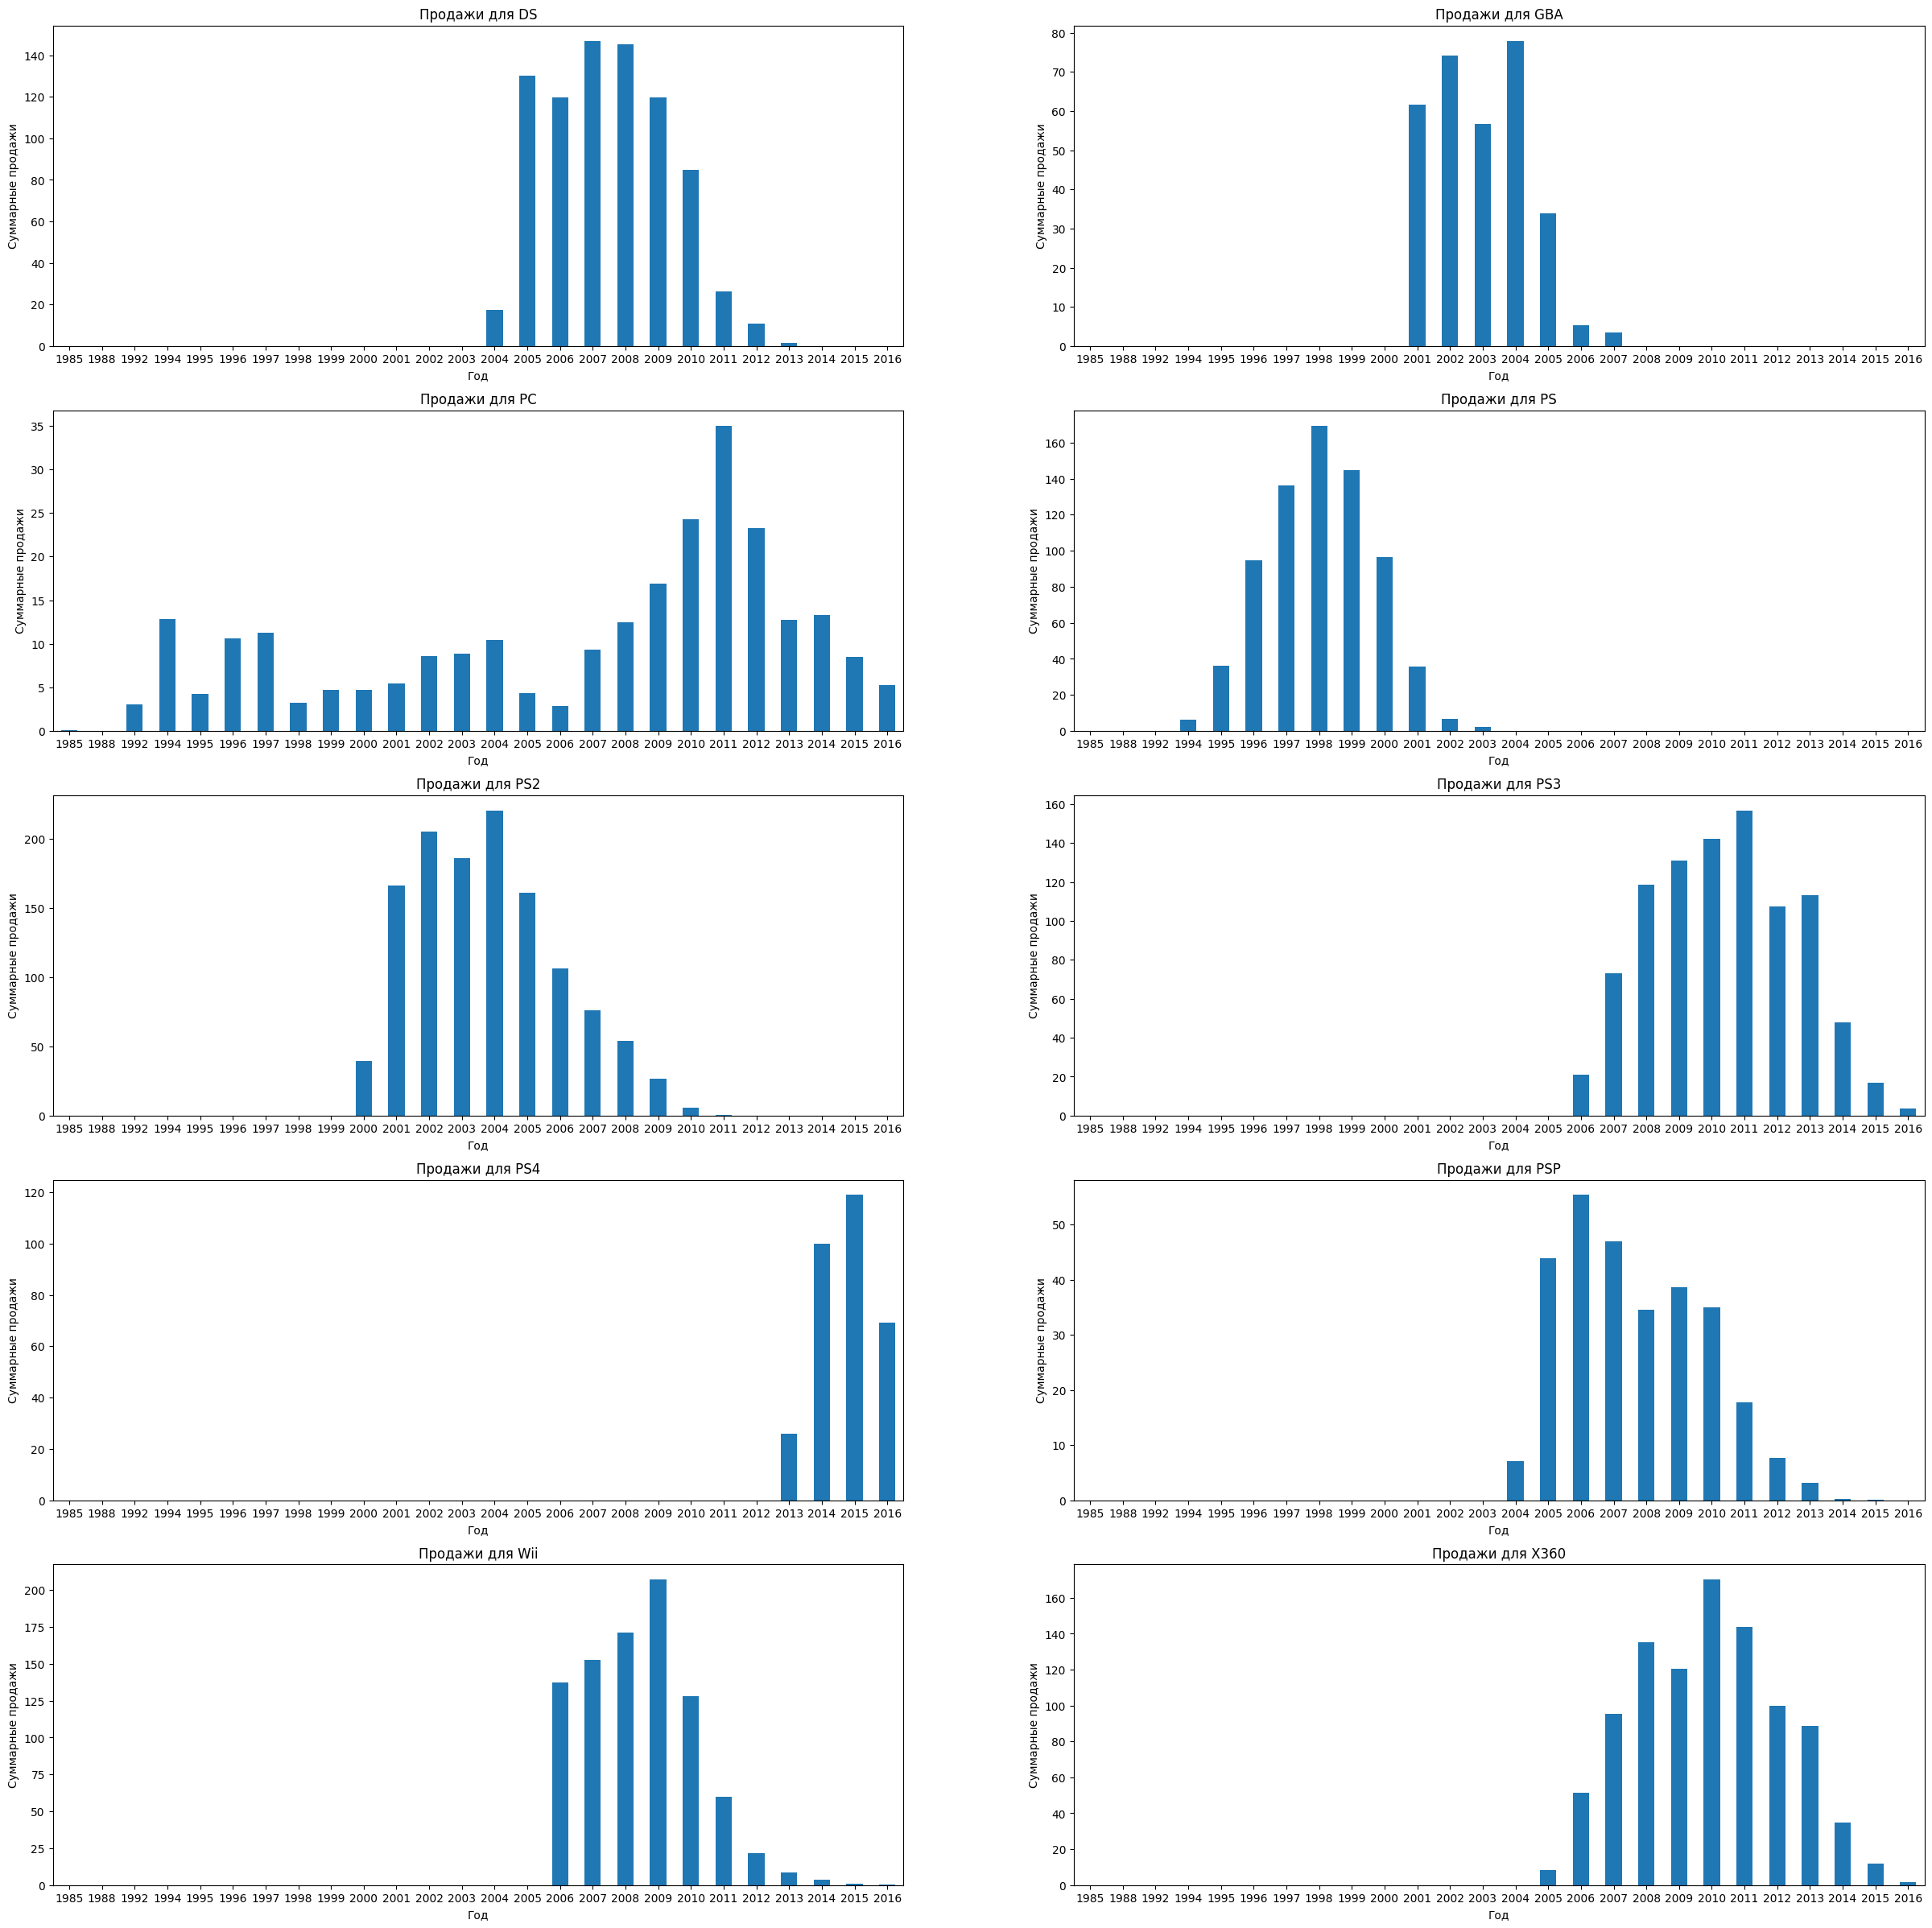

In [35]:
fig, axs = plt.subplots(5, 2, figsize=(30, 30))
for i, platform in enumerate(grouped.index):
    row = i//2
    col = i%2
    grouped.loc[platform].plot(kind='bar', ax=axs[row, col], rot=0)
    axs[row, col].set_title(f'Продажи для {platform}')
    axs[row, col].set_xlabel('Год')
    axs[row, col].set_ylabel('Суммарные продажи')  
plt.show()

**Вывод**: 

Согласно графикам выше, характерный срок для исчезания платформ составляет около 9-10 лет, это хорошо видно для таких платформ как DS,PS,PS2,PS3,PSP,Wii.
При этом разницу в появлении новых платформ можно смотреть на развитии PS, которая стабильно раз в 6-7 лет выпускала новую платформу, соответвенно в 1994,2000,2006,2013, примерно через 2 года после того, как предыдущая платформа достигла своих максимальных по популярности значений.

Интересно, что платформа PC то есть настольных компьютеров то набирает популярность, то снова угасает, но при этом не падает до совсем минимальных значений.Это можно объяснить тем, что персональный компьютер достаточно универсален и сейчас большинство людей в развитых странах может позволить себе хотя бы 1 такой на семью, в то время как различные консоли - узко специализированы для игр и не каждый готов тратить дополнительные деньги на то, что и так можно запустить на персональном компьютере.

### Какие платформы лидируют по продажам, растут или падают? 

Для начала определим актуальный период за который мы будем рассматривать данные: 

из пункта 3.1 нам известно что большая часть выборки приходится на период с 1999 до 2016 года, поэтому нет смысла рассматривать более ранние релизы игр, так как их значения слишком редки.

из пункта 3.2 мы выяснили, что платформа живет около 9-10 лет за редким исключением, а для рождения новой достаточно 6-7 лет, при этом пиковых значений по продажам платформа достигает за первые 5-6 лет, а новое поколение платформы выпускается спустя 2 года после пиковых значений. 

В таком случае, чтобы определить какие платформы лидируют по продажам, будут расти или падать, достаточно принять за актуальный период последние 3 года (с 2014 по 2016 год) - срок достаточный для достижения пиковых значений/видимого спада и для появления новых платформ.

Сделаем срез данных за актуальный период и сгруппируем по платформе и годам, рассмотрим получившиеся значения на диаграммах.

In [36]:
actual_df = df.query('year_of_release>2013')

In [37]:
grouped_actual_df = (actual_df
                     .groupby(['platform','year_of_release'])['total_sales']
                     .sum()
                     .unstack()
                    )

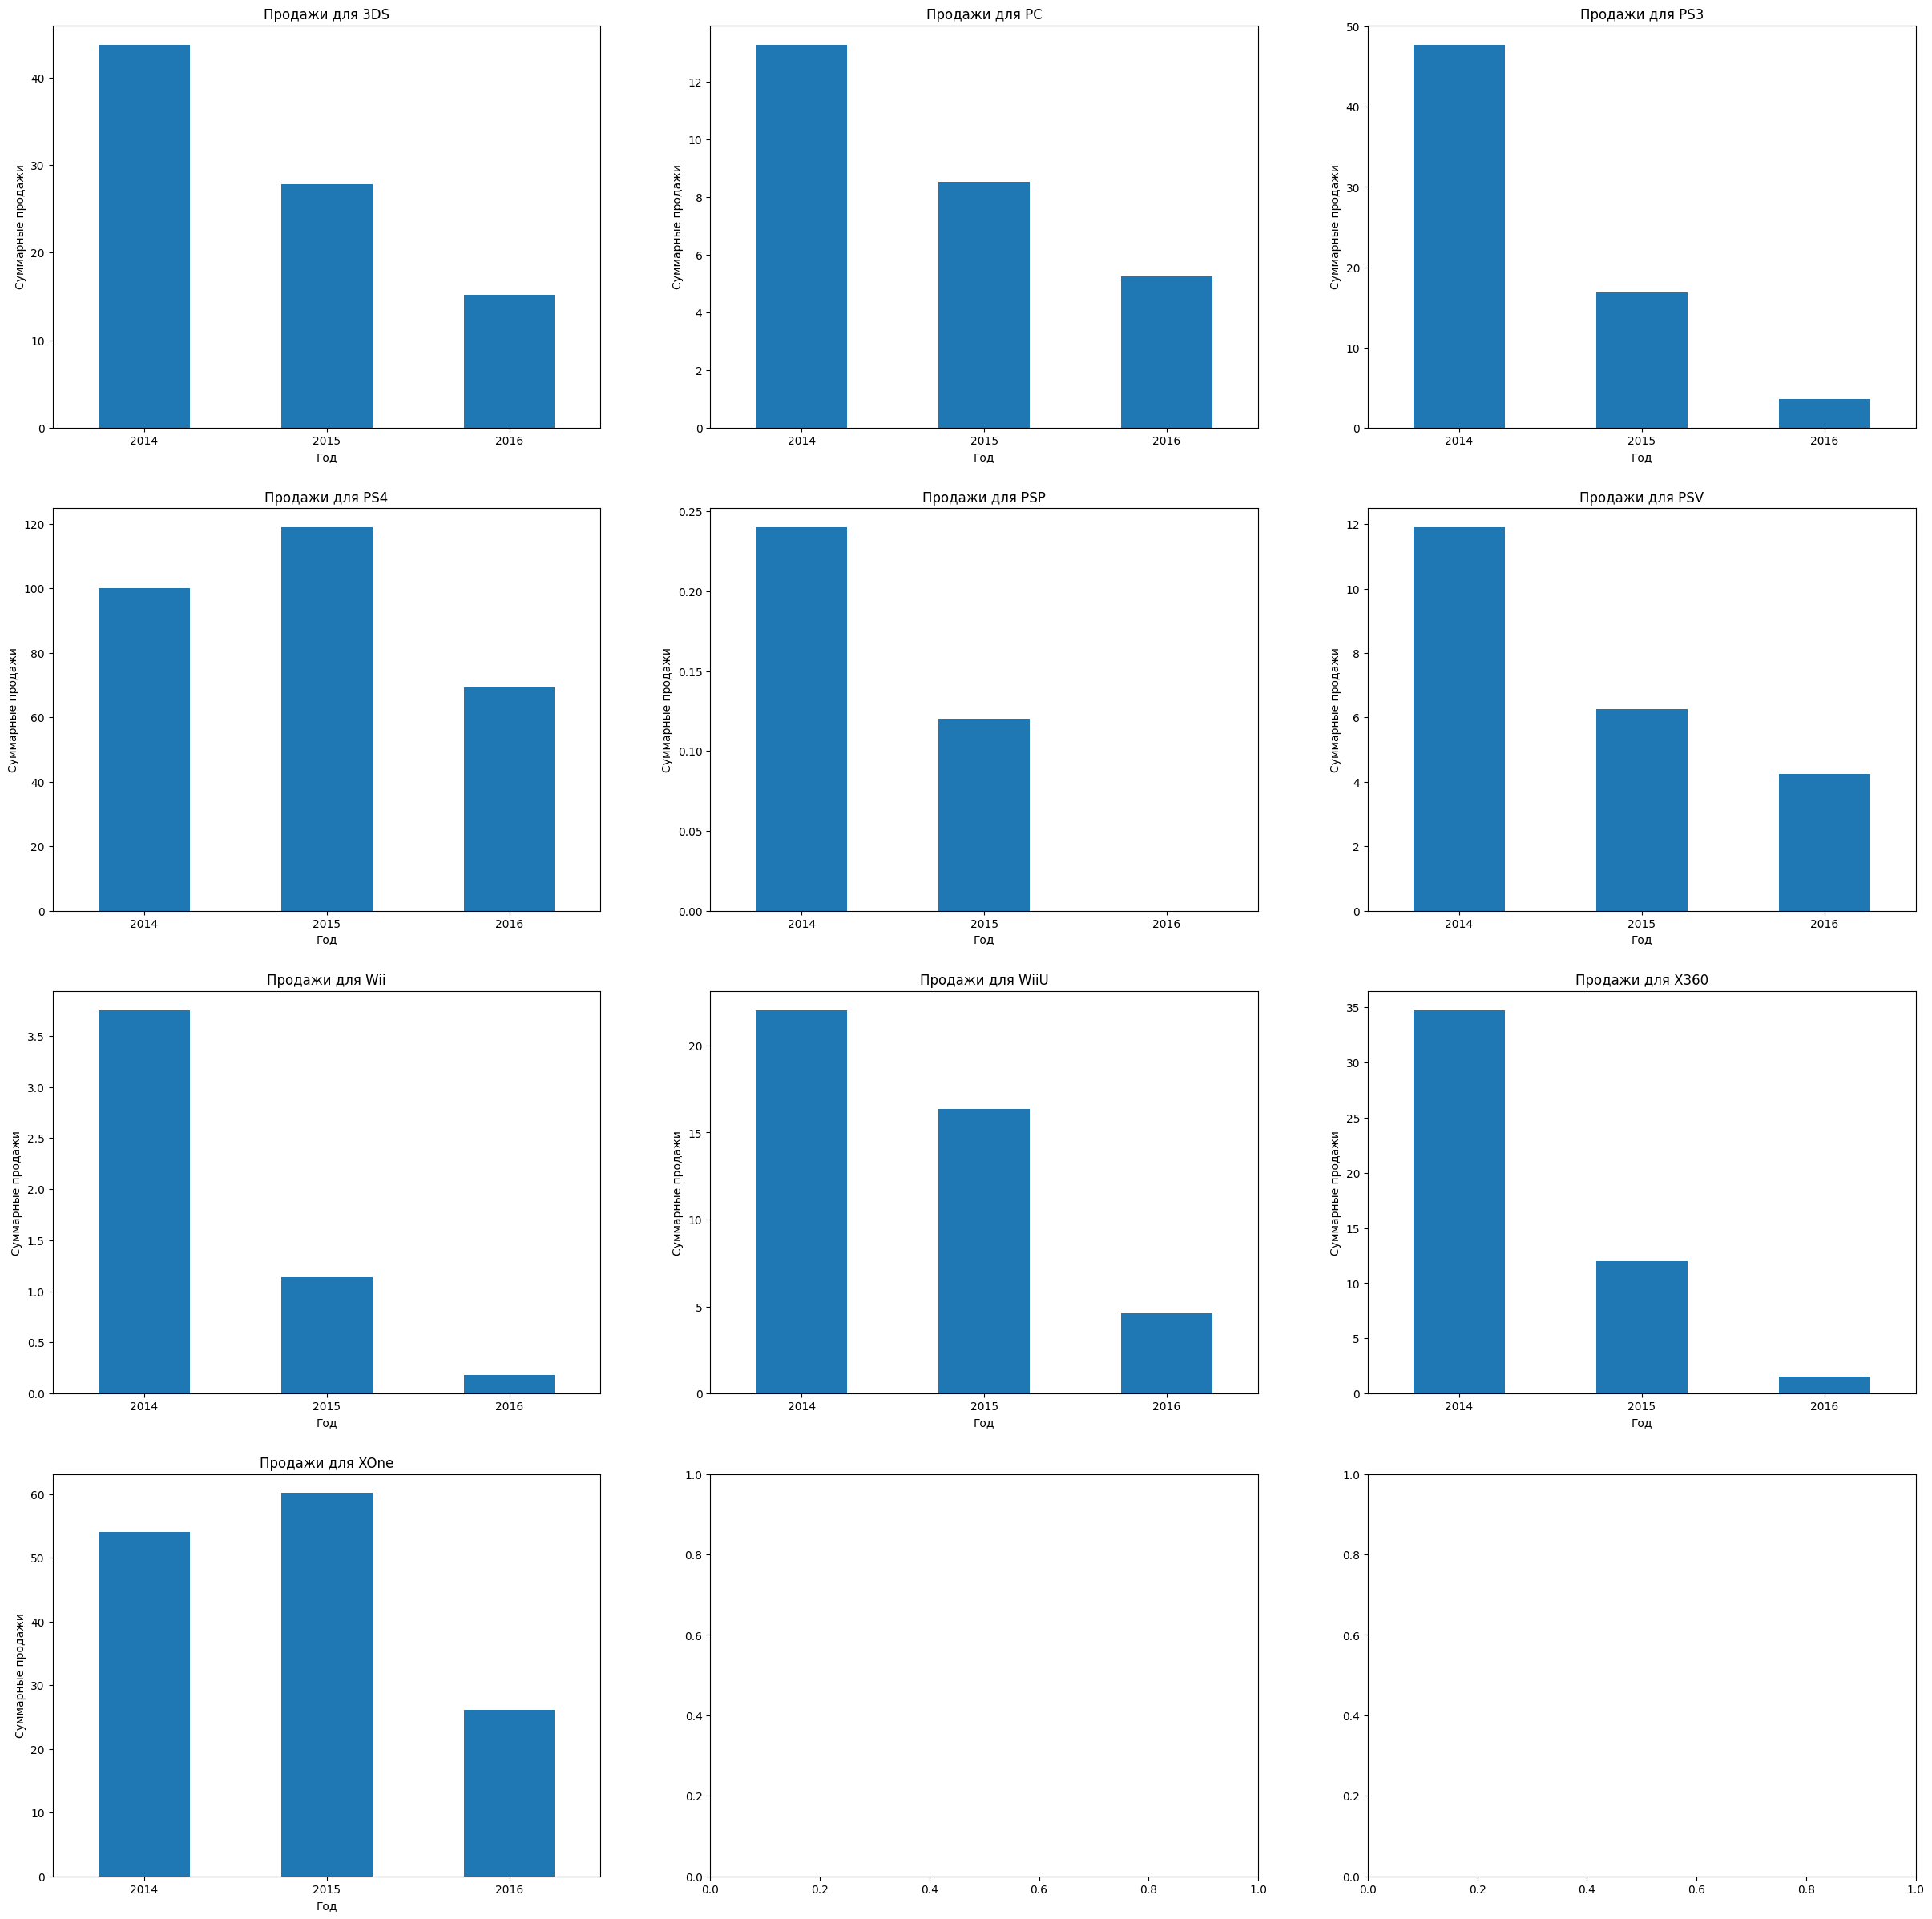

In [38]:
fig, axs = plt.subplots(4,3, figsize=(30, 30))
for i, platform in enumerate(grouped_actual_df.index):
    row = i//3
    col = i%3
    grouped_actual_df.loc[platform].plot(kind='bar', ax=axs[row, col], rot=0)
    axs[row, col].set_title(f'Продажи для {platform}')
    axs[row, col].set_xlabel('Год')
    axs[row, col].set_ylabel('Суммарные продажи')  
plt.show()

Разберем получившиеся диаграммы c учетом того что данные за 2016 год могут быть неполными:

+ Платформы PSP,Wii - Вышли с конкурентного рынка и больше не принесут прибыли

+ Платформаы 3DC,PS3,PSV,X360,PC,WiiU - Потенциально могут принести небольшую прибыль в ближайшие 2 года, однако для них наблюдается тенденция к снижению по продажам и скоро они также выйдут с конкурентного рынка, будучи заменнными новыми поколениями платформ.

+ Платформы PS4, XOne - Несмотря на то что данные за 2016 год невысокие, известно что они могут быть неполными, а также они ещё не дошли или дойдут только в этом году до своих пиковых значений по продажам, поэтому они являются самыми прибыльными среди остальных платформ с тенденцией к росту. Так, PS4 может принести более 120 млн, XOne больше 60 млн.

In [39]:
grouped_actual_df.mean(axis=1).sort_values()

platform
PSP      0.180000
Wii      1.690000
PSV      7.466667
PC       9.016667
WiiU    14.326667
X360    16.073333
PS3     22.726667
3DS     28.893333
XOne    46.786667
PS4     96.050000
dtype: float64

**Вывод**: 
В среднем за актуальный период лидерами по продажам являются PS4,XOne,PS3,3DS,X360. 
Среди которых PS4,XOne имеют тенденцию к росту, остальные к снижению, или они вовсе вышли с рынка.

### Построение "ящика с усами" по глобальным продажам игр в разбивке по платформам.

Оставим только 5 самых прибыльных платформ: PS4,XOne,PS3,3DS,X360 и сгруппируем данные по платформам.

In [40]:
grouped = (actual_df[actual_df['platform'].isin(['PS4','XOne','PS3','3DS','X360'])]
           .groupby('platform')['total_sales']
           .apply(list)
          )

Теперь построим по получившимся группам диаграмму размаха(он же ящик с усами)

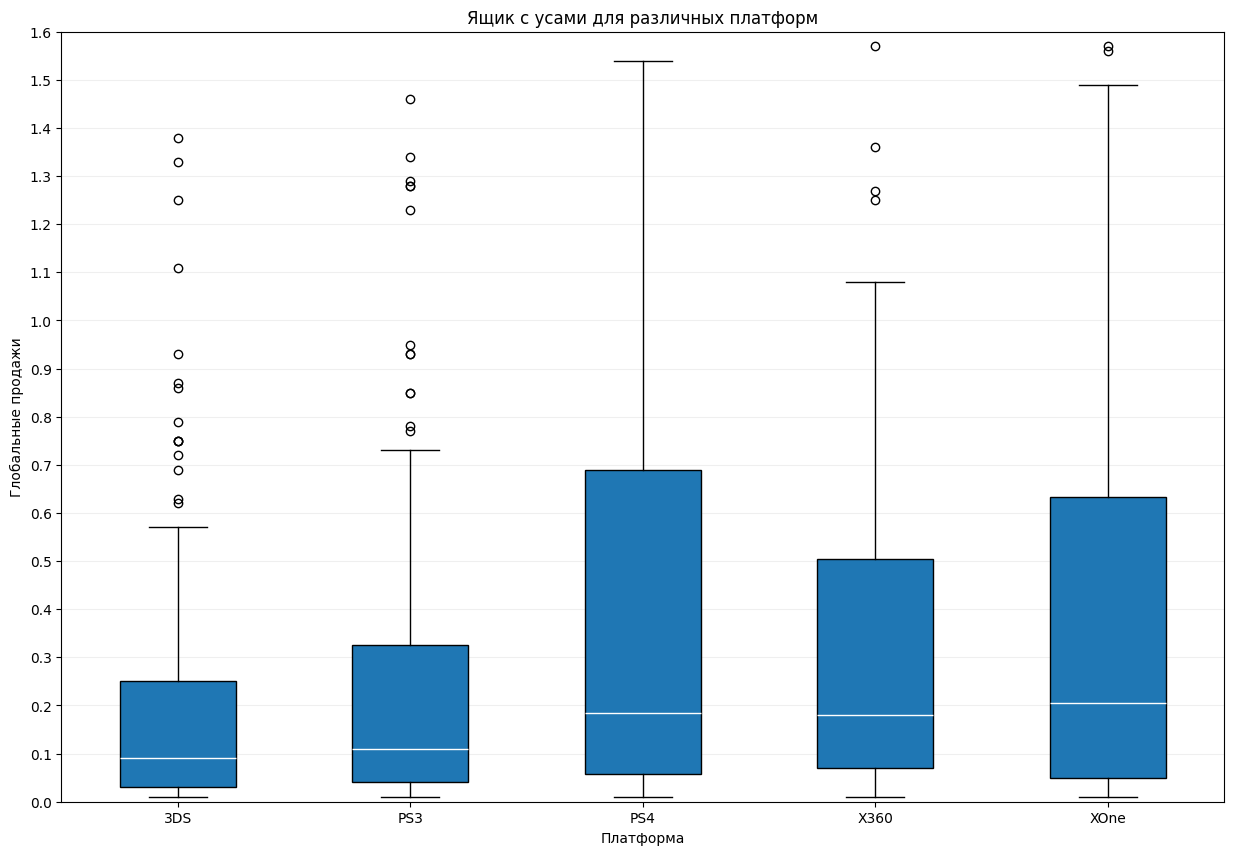

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(grouped.values, patch_artist=True,medianprops=dict(color='white'))

ax.set_title('Ящик с усами для различных платформ')
ax.set_ylabel('Глобальные продажи')
ax.set_xlabel('Платформа')

ax.set_xticklabels(grouped.index, rotation=0)
ax.set_yticks(np.arange(0, 2.1, 0.1))
ax.set_ylim(0, 1.6)

ax.grid(axis='y', alpha=0.2)
plt.show()

**Вывод** на основе получившихся диаграмм размаха:
+ 3DS,PS3 - эти платформы оказались самыми менеее прибыльными:
    + Медианное значение составляет более 0.1 млн, 
    + 75% от выборки - около 0.25-0.35 млн, 
    + Верхняя граница - до 0.8  млн.
+ X360 - эта платформа по показателям чуть лучше предыдущих:
    + Медианное значение составляет почти 0.2 млн, 
    + 75% от выборки -  0.5 млн, 
    + Верхняя граница - почти 1.1 млн.
+ XOne,PS4 - эти платформы оказались самыми прибыльными:
    + Медианное значение составляет более 0.2 млн, 
    + 75% от выборки - около 0.6-0.7 млн, 
    + Верхняя граница составляет более 1.5 млн.


### Корреляция между отзывами и продажами

Для того чтобы выявить то, как влияют на продажи отзывы пользователей и критиков, выберем самую популярную платформу: PS4

In [42]:
print(actual_df['platform'].value_counts().idxmax(),':', actual_df['platform'].value_counts().max())

PS4 : 376


In [43]:
one_platform_df = actual_df.query('platform == "PS4"')

Построим диаграмму рассеяния отдельно для пользователей и критиков, а также расчитаем корреляцию между ними и продажами.

Корреляция между оценками пользователей и продажами:
              total_sales  user_score
total_sales     1.000000   -0.040132
user_score     -0.040132    1.000000


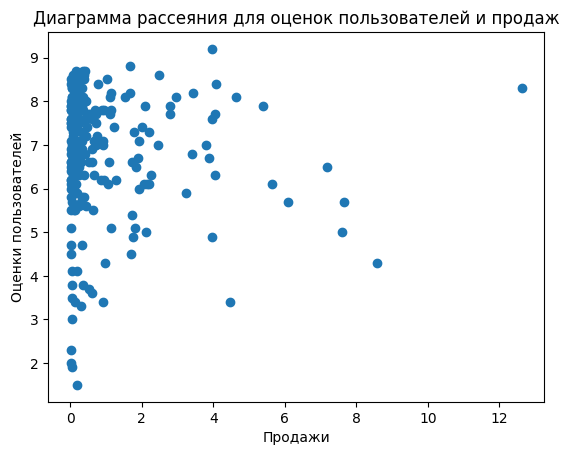

In [44]:
print('Корреляция между оценками пользователей и продажами:\n', \
      one_platform_df[['total_sales','user_score']].corr())
plt.scatter(one_platform_df['total_sales'],one_platform_df['user_score'])
plt.title('Диаграмма рассеяния для оценок пользователей и продаж')
plt.xlabel('Продажи')
plt.ylabel('Оценки пользователей')
plt.show()

Из этой диаграммы и коэффициента корреляции Пирсона следует, что зависимость между оценкой пользователей и продажами игр  отсутвует(-0.04~0). То есть оценки пользователей никак не влияют на суммарные продажи игр.

Корреляция между оценками критиков и продажами: 
               total_sales  critic_score
total_sales      1.000000      0.402661
critic_score     0.402661      1.000000


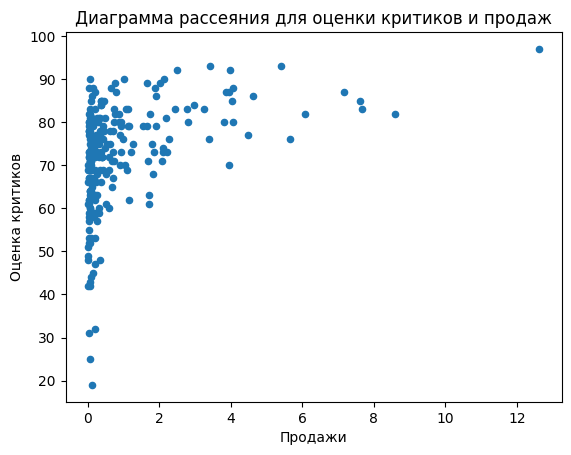

In [45]:
print('Корреляция между оценками критиков и продажами: \n', \
      one_platform_df[['total_sales','critic_score']].corr())

one_platform_df.plot.scatter(x='total_sales',y='critic_score')
plt.title('Диаграмма рассеяния для оценки критиков и продаж')
plt.xlabel('Продажи')
plt.ylabel('Оценка критиков')
plt.show()

Аналогично, зависимость между оценкой критиков и продажами игр очень слабая (0.4), практически отсутвует, хотя и коэффициент корреляции выше чем между оценкой пользователей и продажами. То есть оценки пользователей никак не влияют на суммарные продажи игр, или влияют но совсем незначительно.

### Проверка выявленной корреляции с оценками на других платформах

Для того чтобы проверить, верно ли мы сказали о зависимости между оценками пользователей/критиков и продажами, сгруппируем наши данные по платформе и вычилим коэффициент корреляции для каждой из них:

In [46]:
corr_df = actual_df.groupby('platform')[['total_sales','critic_score','user_score']].corr()
corr_df.xs('total_sales',level=1)

,total_sales,critic_score,user_score
platform,,,
3DS,1.0,0.314117,0.215193
PC,1.0,0.174634,-0.071597
PS3,1.0,0.446575,-0.166761
PS4,1.0,0.402661,-0.040132
PSP,1.0,NaN,NaN
PSV,1.0,0.042665,-0.168455
Wii,1.0,NaN,1.000000
WiiU,1.0,0.370201,0.407926
X360,1.0,0.525723,-0.138445


**Вывод**: зависимость между total_sales и critic_score	user_score очень слабая, независимо от платформы, и для большинства не превышают 0.4

### Распределение игр по жанрам
Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Для того, чтобы сказать о том, какие жанры прибыльные, а какие нет, сгруппируем данные по жанрам и посчитаем общие продажи

In [47]:
grouped = actual_df.groupby('genre')['total_sales']

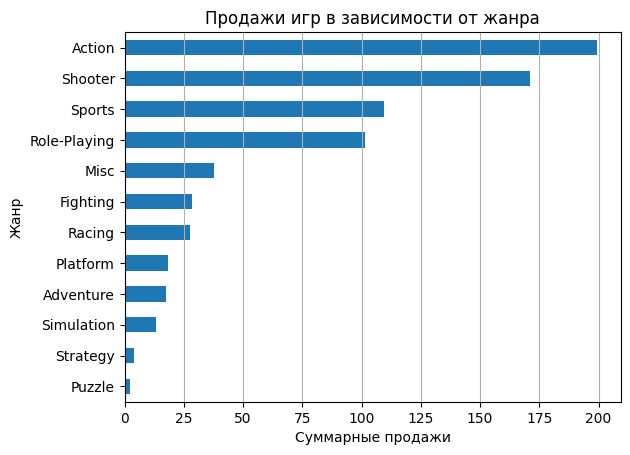

In [48]:
grouped.sum().sort_values().plot.barh();
plt.title('Продажи игр в зависимости от жанра')
plt.ylabel('Жанр')
plt.xlabel('Суммарные продажи')
plt.grid(axis='x')
plt.show()

Также рассмотрим средние и медианные значения

In [49]:
grouped.agg(['median','mean','count']).sort_values(by=['mean'])

,median,mean,count
genre,,,
Adventure,0.030,0.094865,185
Strategy,0.060,0.107027,37
Puzzle,0.045,0.157857,14
Simulation,0.100,0.298409,44
Action,0.090,0.322068,619
Misc,0.090,0.332301,113
Racing,0.090,0.398841,69
Role-Playing,0.110,0.459005,221
Fighting,0.125,0.470333,60


**Вывод**: Не смотря на то, что на диаграмме самыми большими суммарными продажами обладают игры жанра экшен, cамыми прибыльными играми по арифметическому среднему оказались shooter(шутеры) и sports(спортивные), а самые не прибыльные соответвуют жанру puzzles(пазлы), strategy(стратегии) и Adventure(приключения)

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

Рассмотрим топ 5 самых популярных платформ в зависимости от региона.

Для этого сгруппируем данные по платформе и рассмотрим суммарные продажи.

In [50]:
def autopct_format(pct):
    return f'{pct:.1f}%'

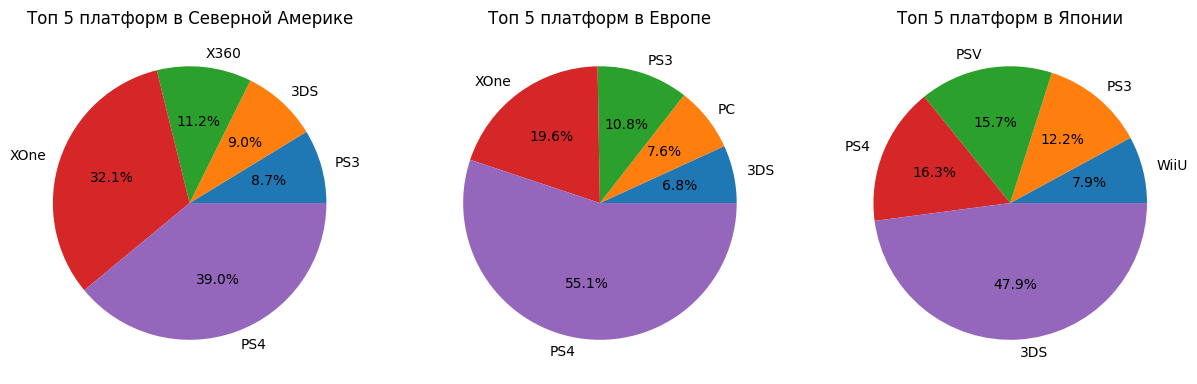

In [51]:
labels = ['na_sales','eu_sales','jp_sales']
names = ['Северной Америке','Европе','Японии']
fig,axs = plt.subplots(1,3,figsize=(15,10))
for i,label in zip(range(0,3),labels):
    
    label_df = actual_df.groupby('platform')[label]
    total_sales = label_df.sum().sum()
    sales_percentage = label_df.sum() / total_sales * 100
    sales_percentage.sort_values().tail().plot.pie(ax=axs[i],autopct=autopct_format)
    
    axs[i].set_title(f'Топ 5 платформ в {names[i]}')
    axs[i].set_ylabel('')
plt.show()

**Вывод** 

Самыми популярными платформами за прошедшие 3 года оказались:
+ Для Северной Америки PS4 - 39%, XOne - 32%, 
+ Для Европы PS4 - 55%, XOne - 20%
+ Для Японии 3DS - 48%, PS4 - 17%

Интересно что первая по пулярности платформа в Японии 3DS оказалась 4 и 5 в Северной Америке и Европе.
Также в Северной Америке более популярной является платформа X360, в Европе PC, а в Японии WiiU

Можно сказать что наиболее выгодно вкладываться в продажи игр на таких платформах как 
+ PS4(для всех регионов),
+ XOne(для Америки и Европы)
+ 3DS(Особенно для Японии)

### Самые популярные жанры (топ-5).

Рассмотрим топ 5 самых популярных жанров в зависимости от региона.

Для этого сгруппируем данные по жанру и рассмотрим суммарные продажи.

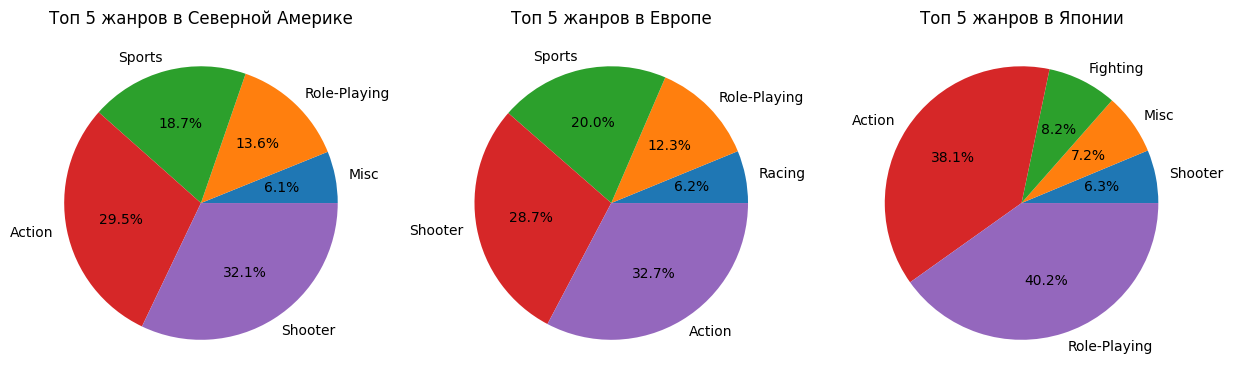

In [52]:
labels = ['na_sales','eu_sales','jp_sales']
names = ['Северной Америке','Европе','Японии']
fig,axs = plt.subplots(1,3,figsize=(15,10))
for i,label in zip(range(0,3),labels):
    
    label_df = actual_df.groupby('genre')[label]
    total_sales = label_df.sum().sum()
    sales_percentage = label_df.sum() / total_sales * 100
    sales_percentage.sort_values().tail().plot.pie(ax=axs[i],autopct=autopct_format)
    
    axs[i].set_title(f'Топ 5 жанров в {names[i]}')
    axs[i].set_ylabel('')

plt.show()

**Вывод** 

Самыми популярными жанрами за прошедшие 3 года оказались:
+ Для Северной Америки Shooter - 32%, Action - 30%
+ Для Европы Action - 33%, Shooter - 29%
+ Для Японии Role-Playing - 40%, Action - 39%

Интересно что первый по пулярности жанр в Японии Role-Playing оказался лишь 4 в Европе и в Америке, также в Японии имеет большую популярность Fighting, которые в Европе и Америке в топ 5 даже не входят.
Также в Америке жанр в топ 5 входит жанр Misc, а в Европе Racing.

Можно сказать что наиболее выгодно вкладываться в продажи игр по следующим жанрам как: 
+ Action,Role-Playing(для всех регионов),
+ Shooter,Sports(для Америки и Европы)
+ Role-Playing особенно, если планируется развивать продажи для Японии.

### Влияние рейтинга ESRB на продажи

Чтобы оценить влияние рейтинга на продажи в зависимости от региона, прежде имеет смысл расписать какие рейтинги вообщее есть в системе ESRB:
+ EC (Early Childhood): Игры, подходящие для детей от 3 лет и старше. 
+ E (Everyone): Игры, подходящие для детей от 6 лет и старше. 
+ E10+ (Everyone 10+): Игры, подходящие для детей от 10 лет и старше. 
+ T (Teen): Игры, подходящие для подростков от 13 лет и старше. 
+ M (Mature): Игры, подходящие для лиц от 17 лет и старше. 
+ RP: отправлено в ESRB, но ещё не оценено

Теперь зная рейтинги уберем рейтинг RP из рассматриваемых, сгруппируем данные по рейтингу и вычислим долю каждого от общих продаж.

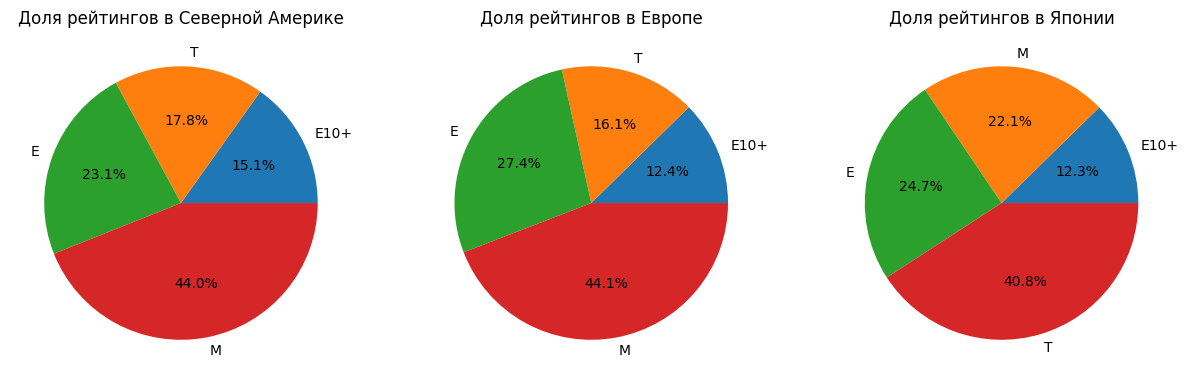

In [53]:
labels = ['na_sales','eu_sales','jp_sales']
names = ['Северной Америке','Европе','Японии']
fig,axs = plt.subplots(1,3,figsize=(15,10))
for i,label in zip(range(0,3),labels):
    
    label_df = actual_df.query('rating != "RP"').groupby('rating')[label]
    total_sales = label_df.sum().sum()
    sales_percentage = label_df.sum() / total_sales * 100
    sales_percentage.sort_values().plot.pie(ax=axs[i],autopct=autopct_format)
    
    axs[i].set_title(f'Доля рейтингов в {names[i]}')
    axs[i].set_ylabel('')

plt.show()

**Вывод** 

Исходя из представленных диаграмм мы можем точно сказать, что продажи зависят от рейтинга, так:
+ Для Северной Америки и Европы рейтинги 17+ составляют около 44%, дальше идут игры 6+ - 23-27% и 13+ - 16-17%
+ Для Японии ситуация иная, здесь преобладают игры с рейтингом 13+ - 41%, дальше 6+ - 25% и только потом игры 17+ - 22%

В таком случае более высокими продажами для Северной Америки и Европы будут обладать игры 17+, для Японии 13+, а для всех 6+
Наименее выгодными будут игры с рейтингом 10+

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Чтобы проверить утверждение выше следует составить нулевую и альтернативную гипотезы:

+ H0: Средняя оценка у пользователей о платформе Xbox One = cредней оценке у пользователей о платформе PC
+ H1: Средняя оценка у пользователей о платформе Xbox One != cредней оценке у пользователей о платформе PC

Нулевую гипотезу я составила из исходного утверждения, альтернативную в качестве противоречия - то есть средние пользовательские рейтинги для заданных платформ больше или меньше посравнению друг с другом, то есть не равны.

Для начала выведем средние значения для представленных выборок:

In [54]:
print('Средняя оценка у пользователей о платформе Xbox One:', actual_df.query('platform == "XOne" ')['user_score'].mean().round(2))
print('Средняя оценка у пользователей о платформе PC:', actual_df.query('platform == "PC" ')['user_score'].mean().round(2))

Средняя оценка у пользователей о платформе Xbox One: 6.59
Средняя оценка у пользователей о платформе PC: 6.3


Проверим наши гипотезы:

за уровень значимости alpha я приняла значение 5%

я использую st.ttest_ind которая используется, когда мы проверяем гипотезу о равенстве двух средних для двух независимых выборок.

In [55]:
alpha = 0.05
result = st.ttest_ind(
    actual_df.query('platform == "XOne" ')['user_score'],
    actual_df.query('platform == "PC" ')['user_score'],
    alternative='two-sided',
    nan_policy='omit'
)
print("p-value: ", result.pvalue)

p-value:  0.10450507919348415


Сделаем вывод об отвержени или неотвержении нулевой гипотезы:

In [56]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


**Нулевая гипотеза** - Средняя оценка у пользователей о платформе Xbox One = cредней оценке у пользователей о платформе PC  - **не отвергнута**, значит мы можем допустить, что средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**

### Средние пользовательские рейтинги жанров Action и Sports разные.

Чтобы проверить утверждение выше следует составить нулевую и альтернативную гипотезы:

+ H0: Средняя оценка у пользователей по жанру Action = cредней оценке у пользователей по жанру Sports
+ H1: Средняя оценка у пользователей по жанру Action != cредней оценке у пользователей по жанру Sports

Принято, что в нулевой гипотезе обязательно нужно ставить равно, поэтому исходное утвреждение я записала в качестве альтернативной, нулевая же гипотеза при её не отвергании будет гласить что возможно рейтинги по этим жанрам равны.

Для начала выведем средние значения для представленных выборок:

In [57]:
print('Средняя оценка у пользователей по жанру Action:', actual_df.query('genre == "Action" ')['user_score'].mean().round(2))
print('Средняя оценка у пользователей по жанру Sports:', actual_df.query('genre == "Sports" ')['user_score'].mean().round(2))

Средняя оценка у пользователей по жанру Action: 6.76
Средняя оценка у пользователей по жанру Sports: 5.23


Проверим наши гипотезы:

за уровень значимости alpha я приняла значение 5%

я использую st.ttest_ind которая используется, когда мы проверяем гипотезу о равенстве двух средних для двух независимых выборок.

In [58]:
alpha = 0.05
result = st.ttest_ind(
    actual_df.query('genre == "Action" ')['user_score'],
    actual_df.query('genre == "Sports" ')['user_score'],
    alternative='two-sided',
    nan_policy='omit'
)
print("p-value: ", result.pvalue)

p-value:  2.8711147985105864e-19


Сделаем вывод об отвержени или неотвержении нулевой гипотезы:

In [59]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


**Нулевая гипотеза** - Средняя оценка у пользователей по жанру Action = cредней оценке у пользователей по жанру Sports  - **отвергнута**, значит мы можем допустить, что cредние пользовательские рейтинги жанров Action и Sports **разные**

## Подведение итогов

В течении проекта была проведена следующая работа:

**Подготовка данных**
+ Название столбцов были приведены к нижнему регистру
+ Были обработаны пропуски в следующих столбцах:
    + name - две строки были удалены
    + year_of_release - часть значений была заменена на, год релиза содержащийся в названии игры, остальное оставлено без изменений
    + genre - были удалены вместе с пропусками в name
    + critic_score - оставлено без изменений
    + user_score - к пропускам добавились значения tbd, остальное оставлено без изменений
    + rating - часть пропусков была заполнена значениями из одинаковых игр с разных платформ, оставшиеся значениями RP
+ Были изменены типы столбцов year_of_release,critic_score на int, а user_score на float
+ Был добавлен новый столбец с суммарными продажами по всем регионам

**Анализ данных**

+ Сколько игр выпускалось в разные годы?:

Выпуск большей части игр приходилось на период после 1999 года, более 99% всей выборки. Однако сказать что данные за предыдущие года нам не важны - сложно, так как многое зависит от поставленной задачи.

+ Как менялись продажи по платформам?:

Характерный срок для исчезания платформ составляет около 9-10 лет.
Количество лет необходимое для появления нового поколения платформ составляет 6-7 лет, примерно через 2 года после того, как предыдущая платформа достигла своих максимальных значений.

Интересно, что платформа PC то есть настольных компьютеров то набирает популярность, то снова угасает, но при этом не падает до совсем минимальных значений.Это можно объяснить тем, что персональный компьютер достаточно универсален и сейчас большинство людей в развитых странах может позволить себе хотя бы 1 такой на семью, в то время как различные консоли - узко специализированы для игр и не каждый готов тратить дополнительные деньги на то, что и так можно запустить на персональном компьютере.

+ Какие платформы лидируют по продажам, растут или падают?

За актуальный период, который мы будем рассматривать данные, приняты последние 3 года (с 2014 по 2016 год) - срок достаточный для достижения пиковых значений и для появления новых платформ. Также нужно учитывать что данные за 2016 год могут быть неполными:

    + Платформы PSP,Wii - Вышли с конкурентного рынка и больше не принесут прибыли

    + Платформаы 3DC,PS3,PSV,X360,PC,WiiU - Потенциально могут принести небольшую прибыль в ближайшие 2 года, однако для них наблюдается тенденция к снижению по продажам и скоро они также выйдут с конкурентного рынка, будучи заменнными новыми поколениями платформ.

    + Платформы PS4, XOne - Являются самыми прибыльными среди остальных платформ с тенденцией к росту. Так, PS4 может принести более 120 млн, XOne больше 60 млн.

В среднем за актуальный период лидерами по продажам являются PS4,XOne,PS3,3DS,X360. 
Среди которых PS4,XOne имеют тенденцию к росту, остальные к снижению, или они вовсе вышли с рынка.

+ Глобальные продажи игр по разбивке по платформам:
    + 3DS,PS3 - эти платформы оказались самыми менеее прибыльными:
        + Медианное значение составляет более 0.1 млн, 
        + 75% от выборки - около 0.25-0.35 млн, 
        + Верхняя граница - до 0.8  млн.
    + X360 - эта платформа по показателям чуть лучше предыдущих:
        + Медианное значение составляет почти 0.2 млн, 
        + 75% от выборки -  0.5 млн, 
        + Верхняя граница - почти 1.1 млн.
    + XOne,PS4 - эти платформы оказались самыми прибыльными:
        + Медианное значение составляет более 0.2 млн, 
        + 75% от выборки - около 0.6-0.7 млн, 
        + Верхняя граница составляет более 1.5 млн.
        
        
+ Корреляция между отзывами и продажами

Зависимость между суммарными продажами и отзывами критиков и пользователей очень слабая, независимо от платформы, и для большинства не превышает 0.4.Это значит что отзывы никак не влияют на суммарные продажи игр независимо от платформы.

+ Распределение игр по жанрам

Самыми прибыльными играми в среднем оказались shooter(шутеры) и sports(спортивные), а самые не прибыльные соответвуют жанру puzzles(пазлы), strategy(стратегии) и аdventure(приключения)

**Портрет пользователя каждого региона**

+ Самые популярные платформы (топ 5) за прошедшие 3 года оказались:
    + Для Северной Америки XOne - 32%, PS4 - 39%
    + Для Европы PS4 - 55%, XOne - 20%
    + Для Японии 3DS - 48%, PS4 - 17%

Интересно что первая по пулярности платформа в Японии 3DS оказалась 4 и 5 в Северной Америке и Европе.
Также в Северной Америке более популярной является платформа X360, в Европе PC, а в Японии WiiU

Наиболее выгодно вкладываться в продажи игр на таких платформах как:

    PS4(для всех регионов),
    XOne(для Америки и Европы)
    3DS(Особенно для Японии)

+ Самые популярные жанры (топ 5) за прошедшие 3 года оказались:
    + Для Северной Америки Action - 30%, Shooter - 32%
    + Для Европы Action - 33%, Shooter - 29%
    + Для Японии Role-Playing - 40%, Action - 39%

Интересно что первый по пулярности жанр в Японии Role-Playing оказался лишь 4 в Европе и в Америке, также в Японии имеет большую популярность Fighting, которые в Европе и Америке в топ 5 даже не входят.
Также в Америке жанр в топ 5 входит жанр Misc, а в Европе Racing.

Наиболее выгодно вкладываться в продажи игр по следующим жанрам как:

    Action,Role-Playing(для всех регионов),
    Shooter,Sports(для Америки и Европы)
    Role-Playing особенно, если планируется развивать продажи для Японии.

+ Влияние рейтинга ESRB (возрастного рейтинга) на продажи:
    + Для Северной Америки и Европы рейтинги 17+ составляют около 44%, дальше идут игры 6+ - 23-27% и 13+ - 16-17%
    + Для Японии ситуация иная, здесь преобладают игры с рейтингом 13+ - 41%, дальше 6+ - 25% и только потом игры 17+ - 22%

Наиболее выгодно вкладываться в игры со следующим рейтингом:

    для всех 6+
    для Северной Америки и Европы: 17+, 
    для Японии 13+, 
    
Наименее выгодными будут игры с рейтингом 10+

**Проверка гипотез**

+ Средние пользовательские рейтинги платформ Xbox Obe и OC одинаковы
Нулевая гипотеза не отвергнута: мы можем допустить, что средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**

+ Средние пользовательские рейтинги жанров Action и Sports разные
Нулевая гипотеза отвергнута: мы можем допустить, что cредние пользовательские рейтинги жанров Action и Sports **разные**


**Наиболее выгодные условия для продажи игр:**

Общемировые:
+ Платформы:
	PS4,XOne c тенденцией к росту;
	PS3,X360,3DC c тенденцией к спаду
    
    
+ Жанры:
	sports(спорт);
	shooter(шутер)

По регионам:
+ Платформы: 
	PS4(для всех регионов),
    XOne(для Америки и Европы)
    3DS(Особенно для Японии)
    
    
+ Жанры:
	Action,Role-Playing(для всех регионов),
    Shooter,Sports(для Америки и Европы)
    Role-Playing (особенно, для Японии)
    
    
+ Возрастной рейтинг:
	6+ для всех;
	17+ для Северной Америки и Европы; 
	13+ для Японии 

**Наименее выгодные условия для продажи игр:**

Обще мировые:

+ Платформы:
	PC,WiiU,PSP,Wii - неконкуретные платформы
    
    
+ Жанры
	puzzles(пазлы);
	strategy(стратегии)
    adventure(приключения)

По регионам:

+ Платформы: 
	PS3 (для Америки);
    3DS (для Европы)
	WiiU (для Японии)
    
    
+ Жанры:
	Misc(для Америки);
    Racing(для Европы)
	Shooter (для Японии)
    
    
+ Возрастной рейтинг:
	10+